In [1]:
import sys
sys.path.append("../")

In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch

In [3]:
! export PYTORCH_ENABLE_MPS_FALLBACK=1

In [4]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [5]:
mps_device = torch.device("mps")
torch.set_default_device(mps_device)

# Format input data

In [6]:
patient = 'R310'
PATH = "../../Data/echidna3/"
path = os.path.join(PATH, patient + "_tumors.h5ad")
print(path)

../../Data/echidna3/R310_tumors.h5ad


In [7]:
w_path = os.path.join(PATH, "all_cellranger_w.csv")
w_path

'../../Data/echidna3/all_cellranger_w.csv'

In [8]:
from echidna.utils import *

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
W = read_W(w_path)

In [10]:
X = sc.read_h5ad(path)
X

AnnData object with n_obs × n_vars = 13371 × 25349
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'sample', 'patient', 'condition', 'barcode_orig', 'barcode_pat', 'samples_per_patient', 'timepoint', 'Before.During.After', 'Sample_J', 'Gender', 'Treatment_phase', 'Drug', 'tissue', 'Mutation', 'sample_group', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'clonotype_id', 'chain', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'frequency', 'proportion', 'cdr3s_aa', 'cdr3s_nt', 'inkt_evidence', 'mait_evidence', 'tcr', 'mait', 'inkt', 'both_chains', 'clone_size', 'mait_inkt', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_origi

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.

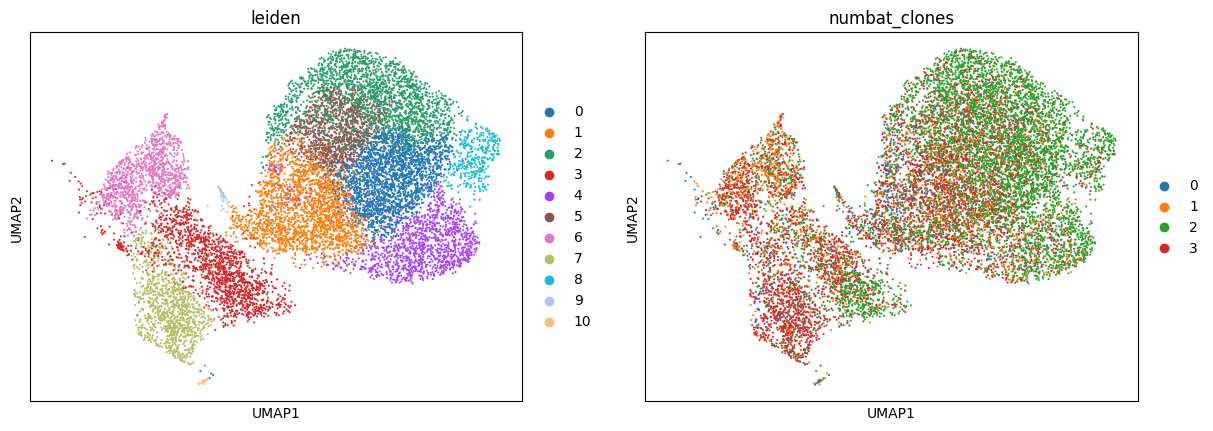

In [11]:
sc.pl.umap(X, color=['leiden', 'numbat_clones'])

In [12]:
X_obs, W_obs, z_obs, pi_obs = prepare_input(X, W, sample_name=patient, 
                                            timepoints=['on2', 'pre'], n_subsamples=3000, device=mps_device)
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2, 3000, 23648])
torch.Size([2, 23648])
torch.Size([2, 3000])
torch.Size([2, 11])


# Train model

In [13]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig

In [14]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_timepoints = X_obs.shape[0]
config.num_clusters = pi_obs.shape[-1]
config.q_corr_init = 1e-2
config.q_shape_rate_scaler = 10.0

In [15]:
echidna = Echidna(config, mode="MT", device=mps_device)

In [22]:
echidna, loss = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=1000)

  3%|▎         | 29/1000 [00:06<03:26,  4.71it/s]/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/pyro/poutine/trace_struct.py:246: UserWarning: Encountered NaN: log_prob_sum at site 'c'
  warn_if_nan(
/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
  3%|▎         | 30/1000 [00:06<03:26,  4.71it/s]/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/pyro/poutine/trace_struct.py:246: UserWarning: Encountered NaN: log_prob_sum at site 'c'
  warn_if_nan(
/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
  3%|▎         | 31/1000 [00:06<03:22,  4.78it/s]/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/pyro/poutine/trace_struct.py:246: UserWarning: Encountered NaN: log_prob_sum at site 'c'
  warn_if_nan(
/User

In [23]:
params = get_learned_params(echidna, X_obs, W_obs, pi_obs, z_obs)

In [24]:
params['c']['value']

tensor([[[3.9698e+23, 2.4200e+24, 2.4784e+22,  ..., 1.2379e+15,
          4.8918e+18, 6.8839e+14],
         [4.2752e+25, 3.7653e+25, 4.2332e+25,  ..., 4.0129e+08,
          6.8000e+11, 4.8071e+12],
         [1.7117e+23, 6.7051e+22, 9.0179e+20,  ..., 4.2666e+11,
          3.3142e+11, 6.1393e+13],
         ...,
         [5.1839e+33, 4.4747e+34, 5.1943e+34,  ..., 3.9656e+23,
          1.2005e+26, 1.1994e+25],
         [3.1326e+34, 1.3613e+36, 2.7358e+35,  ..., 3.2711e+30,
          1.0579e+34, 2.8663e+35],
         [1.0529e+33, 4.4095e+34, 2.0497e+33,  ..., 2.6073e+28,
          3.7562e+26, 3.5313e+26]],

        [[3.5500e+25, 2.3832e+26, 1.1452e+24,  ..., 5.3181e+24,
          2.5931e+25, 1.2219e+27],
         [6.6184e+27, 3.1642e+27, 5.9448e+27,  ..., 6.4543e+24,
          2.3790e+24, 1.5736e+28],
         [1.7326e+25, 8.0073e+24, 1.8871e+23,  ..., 1.1892e+24,
          2.5819e+23, 1.3044e+26],
         ...,
         [3.6092e+34, 2.7174e+36, 1.7220e+36,  ..., 5.4750e+34,
          2.270